# Drug Review Dataset (Druglib.com) Data Set 

Please visit the UCI Machine Learning Repository to download the data set: http://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Druglib.com%29
<br><br>
<b>Summary of Data Set:</b><br>
The dataset provides patient reviews on specific drugs along with related conditions. Furthermore, reviews are grouped into reports on the three aspects benefits, side effects and overall comment. Additionally, ratings are available concerning overall satisfaction as well as a 5 step side effect rating and a 5 step effectiveness rating.<br>
The UCI Repository contains additional information about the dataset.

<br><br>Citation:<br>
<i>Surya Kallumadi <br>
Kansas State University <br>
Manhattan, Kansas, USA <br>
surya '@' ksu.edu <br><br>

Felix Gräßer <br>
Institut für Biomedizinische Technik <br>
Technische Universität Dresden <br>
Dresden, Germany <br>
felix.graesser '@' tu-dresden.de</i>

# Q. The Task
1. Exploratory data analysis - show how the various aspects of the data are related. For example, are drugs with high ratings also highly effective? 
2. Train a model that predicts the drug rating.
3. Explore the model results. For example, why might a drug be highly rated? What sort of side effects contribute to a low rating?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
import re
import numpy as np

In [3]:
df = pd.read_csv('drugLibTrain_raw.tsv', sep='\t')
print(len(df), "observations in train dataset")
df.head()

3107 observations in train dataset


,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


**Attribute Information:**

1. urlDrugName (categorical): name of drug 
2. condition (categorical): name of condition 
3. benefitsReview (text): patient on benefits 
4. sideEffectsReview (text): patient on side effects 
5. commentsReview (text): overall patient comment 
6. rating (numerical): 10 star patient rating 
7. sideEffects (categorical): 5 step side effect rating 
8. effectiveness (categorical): 5 step effectiveness rating

# 1 Exploratory Analysis

## 1.1 Distribution of Ratings 
We begin out exploratory analysis by checking how the ratings are skewed in distribution

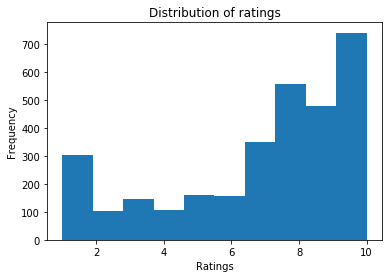

In [4]:
plt.hist(df['rating'])
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of ratings')
plt.show()

## 1.2 ratings vs effectiveness and side effects
It will be interested to see how ratings are affected by side effects and effectiveness <br>
For this representation, side effects and effectiveness are represented numerically as follows:<br>

**Effectiveness**
- "Ineffective":0,
- "Marginally Effective":1,
- "Moderately Effective":2,
- "Considerably Effective":3,
- "Highly Effective":4

**Side Effects**
- "Extremely Severe Side Effects":0,
- "Severe Side Effects":1,
- "Moderate Side Effects":2,
- "Mild Side Effects":3,
- "No Side Effects":4

In [5]:
rating_exp=df[['rating','effectiveness','sideEffects']]
rating_grouped=rating_exp.groupby(['effectiveness','sideEffects']).mean().reset_index()

In [6]:
rating_grouped=rating_exp.groupby(['effectiveness','sideEffects']).mean().reset_index()

In [7]:
effectiveness_dict={"Ineffective":0,
                    "Marginally Effective":1,
                    "Moderately Effective":2,
                    "Considerably Effective":3,
                    "Highly Effective":4
                   }
sideEffects_dict={"Extremely Severe Side Effects":0,
                    "Severe Side Effects":1,
                    "Moderate Side Effects":2,
                    "Mild Side Effects":3,
                    "No Side Effects":4
                   }

In [8]:
rating_grouped['effectiveness']=rating_grouped['effectiveness'].map(lambda l: effectiveness_dict[l])
rating_grouped['sideEffects']=rating_grouped['sideEffects'].map(lambda l: sideEffects_dict[l])

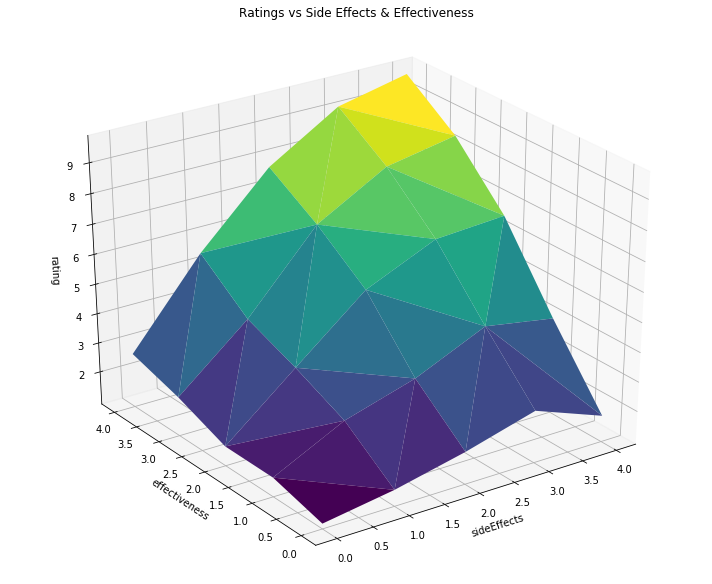

In [9]:
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.plot_trisurf(rating_grouped['sideEffects'], rating_grouped['effectiveness'], rating_grouped['rating'], cmap='viridis', edgecolor='none')
ax.set_xlabel('sideEffects')
ax.set_ylabel('effectiveness')
ax.set_zlabel('rating')
fig.tight_layout()
ax.view_init(30, 235)
plt.title('Ratings vs Side Effects & Effectiveness')
plt.show()



**Observations:**<br>
It is clear from the above 3D plot that highly effective drugs with negligible side effects are rated very highly.

## 1.2 Exploratory Analysis using VaderSentiment
In the Sentiment Analysis area, there are excellent packages available in Python which have been trained over a large corpus of words. One such toolkit is VaderSentiment. VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. <br><br>
The idea behind using VaderSentiment is to use pretrained packages to extract sentiment and check if this sentiment can be a good predictor for ratings of the drugs. Additionally, prediction achieved using these packages create a good baseline to validate the performance for model which we implement later. However, before employing such packages blindly, it is worthwhile to conduct a brief exploratory analysis.

<br>*Some part of description borrowed from https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f*<br>

In [10]:
analyser = SentimentIntensityAnalyzer()
def sentiment_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score
def mean(x1,x2,x3):
    return (x1+x2+x3)/3

In [11]:
df['sideeffects_sentiment']=df['sideEffectsReview'].map(lambda l: sentiment_scores(l)['compound'] if type(l) == str else 0)
df['benefits_sentiment']=df['benefitsReview'].map(lambda l: sentiment_scores(l)['compound'] if type(l) == str else 0)
df['comments_sentiment']=df['commentsReview'].map(lambda l: sentiment_scores(l)['compound'] if type(l) == str else 0)

In [12]:
df['overall_sentiment']=df[['sideeffects_sentiment','benefits_sentiment','comments_sentiment']].mean(axis = 1, skipna = True) 

In [13]:
rating_senti=df[['rating','overall_sentiment']]
rating_senti_avg=rating_senti.groupby('rating').mean().reset_index()

VaderSentiment extracts positive, negative, neutral and compound sentiment from the text. For exploratory analysis, we have used the Compound sentiment only. Furthermore, the sentiment of three review columns **sideEffectsReview**, **benefitsReview** and **commentsReview** are averaged out.

Fig 1.2.1 represents overall sentiment vs ratings with sentiment been extracted directly using vader sentiment package  
Fig 1.2.2 represents overall sentiment vs ratings with sentiment been extracted after removing medical terms appearing in columns **urlDrugName** and **condition**  

  
In the second case, we are removing medical conditions as they may pose a unintentional bias <br>
*For example, Kindey Failure is a medical condition which may add to a negative sentiment*

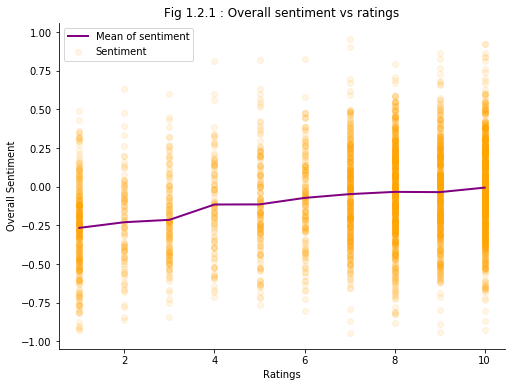

In [14]:
fig, ax=plt.subplots(1,1,figsize=(8,6))
ax.set_ylabel("Overall Sentiment")
ax.set_xlabel("Ratings")
ax.scatter(rating_senti['rating'],rating_senti['overall_sentiment'],alpha=0.1, c='orange', label='Sentiment')
ax.plot(rating_senti_avg['rating'],rating_senti_avg['overall_sentiment'],lw='2',c='purple',label='Mean of sentiment')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
leg = ax.legend()
ax.set_title("Fig 1.2.1 : Overall sentiment vs ratings")
plt.show()

**Observations:** Higher ratings on average have higher mean sentiment

In [15]:
def remove_drug_condition(query,drug_name,condition):
    stopwords=[]
    if type(drug_name) == str:
        stopwords = stopwords + re.sub('[^a-zA-Z ]+', '', drug_name).lower().split()
    if type(condition) == str:
        stopwords = stopwords + re.sub('[^a-zA-Z ]+', '', condition).lower().split()
    result=query
    if len(stopwords)>0:
        querywords = query.split()
        resultwords  = [word for word in querywords if word.lower() not in stopwords]
        result = ' '.join(resultwords)
    return result

In [16]:
df2=pd.DataFrame(df)

In [17]:
for i in df2.index:
    if type(df2['sideEffectsReview'].at[i]) == str:
        df2['sideEffectsReview'].at[i]=remove_drug_condition(df2['sideEffectsReview'].at[i],
                                                             df2['urlDrugName'].at[i],
                                                             df2['condition'].at[i])
for i in df2.index:
    if type(df2['benefitsReview'].at[i]) == str:
        df2['benefitsReview'].at[i]=remove_drug_condition(df2['benefitsReview'].at[i],
                                                             df2['urlDrugName'].at[i],
                                                             df2['condition'].at[i])
for i in df2.index:
    if type(df2['commentsReview'].at[i]) == str:
        df2['commentsReview'].at[i]=remove_drug_condition(df2['commentsReview'].at[i],
                                                             df2['urlDrugName'].at[i],
                                                             df2['condition'].at[i])

In [18]:
df2['sideeffects_sentiment']=df2['sideEffectsReview'].map(lambda l: sentiment_scores(l)['compound'] if type(l) == str else 0)
df2['benefits_sentiment']=df2['benefitsReview'].map(lambda l: sentiment_scores(l)['compound'] if type(l) == str else 0)
df2['comments_sentiment']=df2['commentsReview'].map(lambda l: sentiment_scores(l)['compound'] if type(l) == str else 0)

In [19]:
df2['overall_sentiment']=df2[['sideeffects_sentiment','benefits_sentiment','comments_sentiment']].mean(axis = 1, skipna = True) 

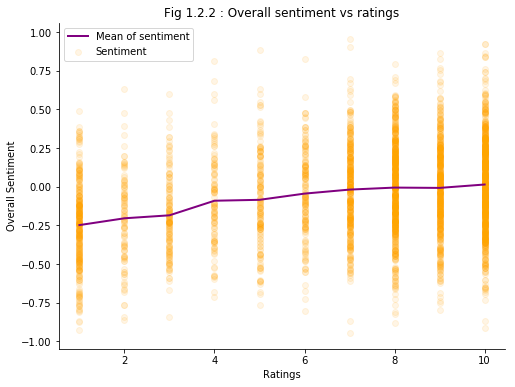

In [20]:
rating_senti=df2[['rating','overall_sentiment']]
rating_senti_avg=rating_senti.groupby('rating').mean().reset_index()
fig, ax=plt.subplots(1,1,figsize=(8,6))
ax.set_ylabel("Overall Sentiment")
ax.set_xlabel("Ratings")
ax.scatter(rating_senti['rating'],rating_senti['overall_sentiment'],alpha=0.1, c='orange', label='Sentiment')
ax.plot(rating_senti_avg['rating'],rating_senti_avg['overall_sentiment'],lw='2',c='purple',label='Mean of sentiment')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
leg = ax.legend()
ax.set_title("Fig 1.2.2 : Overall sentiment vs ratings")
plt.show()

**Observations:** No significant difference from Fig 1.2.1

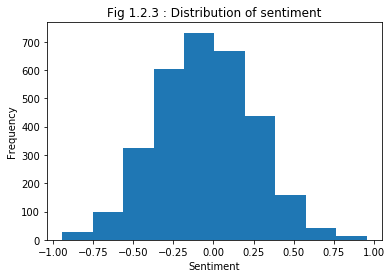

In [21]:
plt.hist(df2['overall_sentiment'])
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Fig 1.2.3 : Distribution of sentiment')
plt.show()

**Observations:** Sentiments are nomally distributed, we can generate a model to predict ratings based on sentiments using Gaussian Naive Bayes

# 2 Machine Learning Models

## 2.1 Gaussian Naive Bayes
Using sentiments extracted from VaderSentiment as features


### 2.1.1 Preprocessing

In [22]:
drugs_train = pd.read_csv('drugLibTrain_raw.tsv', sep='\t')
drugs_test = pd.read_csv('drugLibTest_raw.tsv', sep='\t')

In [23]:
'''
Remove drug names and word in medical condition as it may pose a unintentional bias <br>
For example, Kindey Failure is a medical condition which may add to a negative sentiment
'''
def remove_drug_condition(query,drug_name,condition):
    stopwords=[]
    if type(drug_name) == str:
        stopwords = stopwords + re.sub('[^a-zA-Z ]+', '', drug_name).lower().split()
    if type(condition) == str:
        stopwords = stopwords + re.sub('[^a-zA-Z ]+', '', condition).lower().split()
    result=query
    if len(stopwords)>0:
        querywords = query.split()
        resultwords  = [word for word in querywords if word.lower() not in stopwords]
        result = ' '.join(resultwords)
    return result
def clean_drug_review(df,review_field):
    for i in df.index:
        if type(df[review_field].at[i]) == str:
            df[review_field].at[i]=remove_drug_condition(df[review_field].at[i],
                                                             df['urlDrugName'].at[i],
                                                             df['condition'].at[i])

In [24]:
clean_drug_review(drugs_train,'sideEffectsReview')
clean_drug_review(drugs_train,'benefitsReview')
clean_drug_review(drugs_train,'commentsReview')
clean_drug_review(drugs_test,'sideEffectsReview')
clean_drug_review(drugs_test,'benefitsReview')
clean_drug_review(drugs_test,'commentsReview')

### 2.1.2 Set up Vader Sentiment

In [25]:
analyser = SentimentIntensityAnalyzer()
def sentiment_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

### 2.1.3 Extract sentiments from reviews using VaderSentiment
Feature Extraction

In [26]:
def extract_sentiment(df,review_field):
    df[review_field+"_pos"]=df[review_field].map(lambda l: sentiment_scores(l)['pos'] if type(l) == str else 0)
    df[review_field+"_neg"]=df[review_field].map(lambda l: sentiment_scores(l)['neg'] if type(l) == str else 0)
    df[review_field+"_neu"]=df[review_field].map(lambda l: sentiment_scores(l)['neu'] if type(l) == str else 0)
    df[review_field+"_compound"]=df[review_field].map(lambda l: sentiment_scores(l)['compound'] if type(l) == str else 0)

In [27]:
extract_sentiment(drugs_train,'sideEffectsReview')
extract_sentiment(drugs_train,'benefitsReview')
extract_sentiment(drugs_train,'commentsReview')
extract_sentiment(drugs_test,'sideEffectsReview')
extract_sentiment(drugs_test,'benefitsReview')
extract_sentiment(drugs_test,'commentsReview')

In [28]:
columns_drop=['Unnamed: 0','urlDrugName','effectiveness','sideEffects','condition','benefitsReview','sideEffectsReview','commentsReview']
drugs_train_clean=drugs_train.drop(columns_drop,axis=1)
drugs_test_clean=drugs_test.drop(columns_drop,axis=1)

### 2.1.4  Model to predict ratings 1 to 10

In [29]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB, ComplementNB
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn import svm
from sklearn.metrics import accuracy_score

In [30]:
model = GaussianNB()
X_train=drugs_train_clean[drugs_train_clean.columns.difference(['rating'])]
y_train=drugs_train_clean['rating']

X_test=drugs_test_clean[drugs_train_clean.columns.difference(['rating'])]
y_test=drugs_test_clean['rating']

In [31]:
model.fit(X_train,y_train)
y_pred_nb = model.predict(X_test)

In [32]:
print(accuracy_score(y_test, y_pred_nb))

0.25386100386100385


**Observations**: With 10 labels accuracy we are getting is 0.25 which is way less than desired. As expected predicting 10 labels is too much of a task for this model. However, we can categorize the performance of drugs in less labels.

In the next part, we reduce the number of labels to 3 with -1 indicating poorly rated drugs, 1 indicating highly rated drugs and 0 being avarage rating.

In [33]:
def reduce_label(rating):
    """ maps 0-10 rating to Positive (1), Neutral (0), or Negative (-1)"""
    if rating > 6:
        return 1
    elif rating > 4:
        return 0
    else:
        return -1

### 2.1.5  Model to predict if drugs is a poor, average or a high performer

In [34]:
X_train=drugs_train_clean[drugs_train_clean.columns.difference(['rating'])]
y_train=drugs_train_clean['rating'].map(lambda l:reduce_label(l))

X_test=drugs_test_clean[drugs_train_clean.columns.difference(['rating'])]
y_test=drugs_test_clean['rating'].map(lambda l:reduce_label(l))

In [35]:
model = GaussianNB()
model.fit(X_train,y_train)
y_pred_nb = model.predict(X_test)
y_pred_tr_nb = model.predict(X_train)

In [36]:
print('Testing Accuracy: '+str(accuracy_score(y_test, y_pred_nb)))
print('Training Accuracy: '+str(accuracy_score(y_train, y_pred_tr_nb)))

Testing Accuracy: 0.6476833976833977
Training Accuracy: 0.6717090440939814


**Observations:** Accuracy is much better.

## 2.2 Predicting drug rating without extracting sentiment 
Here we attempt to predict drug rating using the words from three review sets directly

In [37]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import itertools

In [38]:
stopwords_set=set(stopwords.words('english'))

In [39]:
drugs_train[['rating','benefitsReview','sideEffectsReview','commentsReview']].head()

,rating,benefitsReview,sideEffectsReview,commentsReview
0,4,slowed the progression left ventricular dysfun...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,1,Although this type of control has more cons th...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Control, I Would Not Suggest This ..."
2,10,I was used to having so badly that they would ...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my and then eve...
3,3,The went away for a few months after just a fe...,"Constipation, dry mouth and some mild dizzines...",I was given prescription at a dose of 45mg per...
4,2,I think that the was starting to help with the...,I felt extremely drugged and dopey. Could not ...,See above


### 2.2.1 Combine three sets of reviews into one for both training and testing data set

In [40]:
drug_reviews_train=pd.concat(
    [drugs_train['rating'],
     drugs_train['commentsReview'].replace(np.nan,"") \
     .str.cat(drugs_train['sideEffectsReview'].replace(np.nan,""),sep=" ") \
     .str.cat(drugs_train['benefitsReview'].replace(np.nan,""),sep=" ")],
    axis=1)


In [41]:
drug_reviews_test=pd.concat(
    [drugs_test['rating'],
     drugs_test['commentsReview'].replace(np.nan,"") \
     .str.cat(drugs_test['sideEffectsReview'].replace(np.nan,""),sep=" ") \
     .str.cat(drugs_test['benefitsReview'].replace(np.nan,""),sep=" ")],
    axis=1)

In [42]:
def make_xy(reviews, vectorizer=None):
    verdict=reviews[['rating','commentsReview']]
    if vectorizer == None:
        vectorizer=CountVectorizer(min_df=0,stop_words=stopwords_set)
        vectorizer.fit(np.array(verdict['commentsReview']))
    X = vectorizer.transform(np.array(verdict['commentsReview']))
    rating = np.array(verdict['rating'])
    Y=[1 if i>6 else 0 if i>4 else -1 for i in rating]
    return X, Y


### 2.2.2 Extract tf-idf features and generate train and test data

In [43]:
vectorizer=CountVectorizer(min_df=0,stop_words=stopwords_set)
vectorizer.fit(np.array(drug_reviews_train['commentsReview']))
X_train, y_train = make_xy(drug_reviews_train, vectorizer)
X_test, y_test = make_xy(drug_reviews_test, vectorizer)

In [44]:
X_train=X_train.toarray()
X_test=X_test.toarray()

### 2.2.3 Set up model and compare performance

In [45]:
model = GaussianNB()
model.fit(X_train,y_train)
y_pred_nb = model.predict(X_test)
y_pred_tr_nb = model.predict(X_train)

In [46]:
print('Testing Accuracy: '+str(accuracy_score(y_test, y_pred_nb)))
print('Training Accuracy: '+str(accuracy_score(y_train, y_pred_tr_nb)))

Testing Accuracy: 0.5694980694980695
Training Accuracy: 0.939491470872224


**Observations:**<br>
Since testing accuracy is much lesser than the training accuracy, this is a case of over fitting. Overfitting may happen for various reasons. In the further sections, we not only try to deal with overfitting using common techniques but also try a different approach as it is possible the model used currently is not suited for this kind of problem.

### 2.3 Deal with overfitting

**2.3.1 Add drugnames and conditions to stopwords set**

In [47]:
condition_words=list(drugs_train['condition'].map(lambda l: re.sub('[^a-zA-Z ]+', ' ', l) if type(l)==str else "").map(lambda l:l.split(" ")))
condition_words=list(set(itertools.chain.from_iterable(condition_words)))
condition_words=[w if len(w)>=2 else '#None#' for w in condition_words]
condition_words.remove('#None#')

In [48]:
drugnames_words=list(drugs_train['urlDrugName'].map(lambda l: re.sub('[^a-zA-Z ]+', ' ', l) if type(l)==str else "").map(lambda l:l.split(" ")))
drugnames_words=list(set(itertools.chain.from_iterable(drugnames_words)))
drugnames_words=[w if len(w)>=2 else '#None#' for w in drugnames_words]
drugnames_words.remove('#None#')

In [49]:
stopwords_set_custom=stopwords_set.union(set(condition_words)).union(set(drugnames_words))

**2.3.2 Remove execessively large reviews**

In [50]:
reviews_by_length=np.array(drug_reviews_train['commentsReview'].map(lambda l:len(l)))

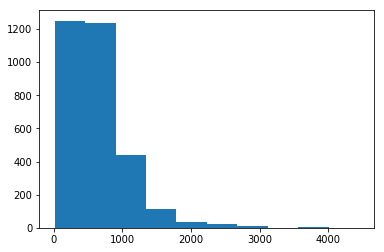

In [51]:
plt.hist(reviews_by_length)
plt.show()

In [52]:
drug_reviews_train2=pd.DataFrame(drug_reviews_train)
drug_reviews_train2['review_length']=drug_reviews_train2['commentsReview'].map(lambda l:len(l))
drug_reviews_train2=drug_reviews_train2[drug_reviews_train2['review_length']<=2000]

In [53]:
vectorizer=CountVectorizer(min_df=0,stop_words=stopwords_set_custom)
vectorizer.fit(np.array(drug_reviews_train['commentsReview']))
X_train, y_train = make_xy(drug_reviews_train, vectorizer)
X_test, y_test = make_xy(drug_reviews_test, vectorizer)

In [54]:
X_train=X_train.toarray()
X_test=X_test.toarray()

In [55]:
model = GaussianNB()
model.fit(X_train,y_train)
y_pred_nb = model.predict(X_test)
y_pred_tr_nb = model.predict(X_train)

In [56]:
print('Testing Accuracy: '+str(accuracy_score(y_test, y_pred_nb)))
print('Training Accuracy: '+str(accuracy_score(y_train, y_pred_tr_nb)))

Testing Accuracy: 0.5472972972972973
Training Accuracy: 0.9279047312520116


**Observations:**<br>
Even after trying varous approaches to deal with over fitting, there is not significant difference in the accuracy. In the next section, we use Multinomoal Naive Bayes.

### 2.4 Multinomial Naive Bayes


#### 2.4.1 Model Fitting and Accuracy Evaluation

In [57]:
model = MultinomialNB()
model.fit(X_train,y_train)
y_pred_nb = model.predict(X_test)
y_pred_tr_nb = model.predict(X_train)

In [58]:
print('Testing Accuracy: '+str(accuracy_score(y_test, y_pred_nb)))
print('Training Accuracy: '+str(accuracy_score(y_train, y_pred_tr_nb)))

Testing Accuracy: 0.6978764478764479
Training Accuracy: 0.8751206952043772


The testing accuracy we achieve is about 70%, however, we can improve this accuracy by using regularization

#### 2.4.2 Estimating alpha

In [59]:
alphas=np.arange(1,20)*0.1
accuracy_train=[]
accuracy_test=[]
for alpha in alphas:
    model = ComplementNB(alpha=alpha)
    model.fit(X_train,y_train)
    y_pred_nb = model.predict(X_test)
    y_pred_tr_nb = model.predict(X_train)
    accuracy_test.append(accuracy_score(y_test, y_pred_nb))
    accuracy_train.append(accuracy_score(y_train, y_pred_tr_nb))

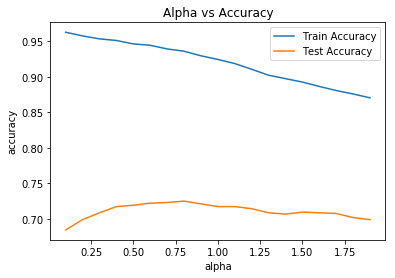

In [60]:
plt.plot(alphas,accuracy_train,label='Train Accuracy')
plt.plot(alphas,accuracy_test,label='Test Accuracy')
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.legend()
plt.title('Alpha vs Accuracy')
plt.show()

### 2.5 Final Model
Multinomoal Naive Bayes with alpha=0.75 gives the best testing accuracy


In [61]:
model = MultinomialNB(alpha=0.75)
model.fit(X_train,y_train)
y_pred_nb = model.predict(X_test)
y_pred_tr_nb = model.predict(X_train)

In [62]:
print('Testing Accuracy: '+str(accuracy_score(y_test, y_pred_nb)))
print('Training Accuracy: '+str(accuracy_score(y_train, y_pred_tr_nb)))

Testing Accuracy: 0.7123552123552124
Training Accuracy: 0.9008690054715159


**Observations**: <br>
So far we are able to achieve an accuracy of 0.71 which is decent however much lesser than the training accuracy. This could be a potential case of overfitting. Analyzing it further as to which words could be better predictors of classes can perhaps give us more insights.

## 3 Result Explorations
List of words along with their corresponding probabilities which best predict three classes

In [63]:
import scipy.sparse as sp

In [64]:
identity=sp.identity(X_train.shape[1])
probs=model.predict_proba(identity)
vec=pd.DataFrame(vectorizer.get_feature_names(), columns=['Features'])

In [65]:
print('10 words that best predicts bad drug rating')
vec['probs']=probs[:,0]
vec.sort_values(by=['probs'],ascending=False).head(10)

10 words that best predicts bad drug rating


,Features,probs
7893,percocette,0.814170
9675,shrinkage,0.788681
4812,gait,0.788681
7875,penile,0.788681
10762,tendon,0.788681
559,ached,0.788681
6470,lovastatin,0.788681
2973,darvacet,0.788681
8544,puppy,0.788681
1999,cart,0.788681


In [66]:
print('10 words that best predicts neutral drug rating')
vec['probs']=probs[:,1]
vec.sort_values(by=['probs'],ascending=False).head(10)

10 words that best predicts neutral drug rating


,Features,probs
9223,rivotril,0.729412
7065,murad,0.729412
5970,irritant,0.690100
6502,luvox,0.644790
6702,medicament,0.637423
11439,unsurprisingly,0.637423
6519,macrodantin,0.637423
6137,l5,0.637423
10213,stitches,0.637423
8336,proactiv,0.637423


In [67]:
print('10 words that best predicts good drug rating')
vec['probs']=probs[:,2]
vec.sort_values(by=['probs'],ascending=False).head(10)

10 words that best predicts good drug rating


,Features,probs
2584,consistently,0.956950
1960,capsule,0.950487
4148,excellent,0.948678
6545,maintenance,0.943224
6541,maintained,0.936472
2459,complexion,0.932456
9016,repeat,0.932456
6323,lifted,0.930502
2626,content,0.927898
1804,bring,0.927898


**Observations**: <br>
We do see words like *excellent*, *consistently*, etc being predictors of good ratings. While words like *unsurprizingly* predicting  neutral ratings and *ached* predicting bad ratings. However, in the above tables, more often than not we see words such as rivotril, percocette, etc which are drug/chemical compound names and ideally shouldn't be an indicator whether the drug is performing good or not. We may need to perform a better text preprocessing to counter this issue. It is also possible some of the chemical compund / drug names are consistently associated with poor drugs. In this case, some domain expertise may be needed to evaluate it further.

## 4 Next Steps
While this model gives decent accuracy in predicting the drug rating using the sentiment/content of the reviews, it can be improved upon. A more robust text preprocessing may increase the overall accuracy metric and perhaps employing deep learning techniques may give a further boost to the model performance. <br>
  
With due respect in an interest of time, this will be my final submission for the coding round. <br>
*- AJ (Ajinkya) <br>ajinkya@uw.edu*

## Thank You